## Зависимость вероятности победы персонажа от продолжительности матча
По мотивам: https://www.reddit.com/r/DotA2/comments/8071nn/graphs_of_the_heroes_win_rate_based_on_game/ 

Аналогичный анализ можно провести по предметам, в репозитории имеется файл с описаниями `items.json`

In [1]:
import json
from IPython.display import display

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from opendota import *

In [2]:
PATH_HEROES_DESC = 'static/heroes.json'
with open(PATH_HEROES_DESC, 'r') as json_file:
    heroes = json.load(json_file)

In [3]:
heroid2name = {k: v['name'] for k, v in heroes.items()}
heroname2id = {v.replace('_', '').replace('npcdotahero', ''): k for k, v in heroid2name.items()}
print(heroname2id)

{'antimage': '1', 'axe': '2', 'bane': '3', 'bloodseeker': '4', 'crystalmaiden': '5', 'drowranger': '6', 'earthshaker': '7', 'juggernaut': '8', 'mirana': '9', 'morphling': '10', 'nevermore': '11', 'phantomlancer': '12', 'puck': '13', 'pudge': '14', 'razor': '15', 'sandking': '16', 'stormspirit': '17', 'sven': '18', 'tiny': '19', 'vengefulspirit': '20', 'windrunner': '21', 'zuus': '22', 'kunkka': '23', 'lina': '25', 'lion': '26', 'shadowshaman': '27', 'slardar': '28', 'tidehunter': '29', 'witchdoctor': '30', 'lich': '31', 'riki': '32', 'enigma': '33', 'tinker': '34', 'sniper': '35', 'necrolyte': '36', 'warlock': '37', 'beastmaster': '38', 'queenofpain': '39', 'venomancer': '40', 'facelessvoid': '41', 'skeletonking': '42', 'deathprophet': '43', 'phantomassassin': '44', 'pugna': '45', 'templarassassin': '46', 'viper': '47', 'luna': '48', 'dragonknight': '49', 'dazzle': '50', 'rattletrap': '51', 'leshrac': '52', 'furion': '53', 'lifestealer': '54', 'darkseer': '55', 'clinkz': '56', 'omnikni

In [4]:
def hero_info(some_identifier):
    some_identifier = str(some_identifier)
    if some_identifier.isdigit():
        hero_id = some_identifier
        hero = heroid2name[hero_id].replace('npc_dota_hero_', '')
    else:
        hero = some_identifier
        hero_id = heroname2id[some_identifier]
    return hero_id, hero

In [5]:
def hero_matches(hero_id, n=1000):
    """
    Возвращает матчи, в которых присутствовал данный персонаж
    """
    q = '''
    select
        matches.duration,
        matches.match_id,
        matches.start_time,
        ((player_matches.player_slot < 128) = matches.radiant_win) win,
        player_matches.hero_id,
        match_patch.patch
    from matches 
        join player_matches using(match_id)
        join match_patch using(match_id)
    where 
        duration is not null and
        --match_patch.patch >= '7.09' and
        player_matches.hero_id = '{}'     
    limit {}
    '''.format(hero_id, n)
    
    return query_opendota(q) 

In [6]:
def hero_winrate(hero_id, n_matches=1000, periods=10, 
        min_minutes_duration=None, max_minutes_duration=None):
    """
    Разбивает время на периоды, для каждого периода подсчитывает винрейт персонажа
    :param min_minutes_duration: минимальная продолжительность матча
    :param max_minutes_duration: максимальная продолжительность матча
    """
    df_matches = hero_matches(hero_id, n_matches)
    n_matches_actual = df_matches.shape[0]
    df_matches['duration_minutes'] = (df_matches.duration // 60)
    
    if min_minutes_duration is not None:
        df_matches = df_matches.query(
            'duration_minutes >= {}'.format(min_minutes_duration)).copy()
    
    if max_minutes_duration is not None:
        df_matches = df_matches.query(
            'duration_minutes <= {}'.format(max_minutes_duration)).copy()
    
    df_matches['duration_period'] = pd.cut(df_matches.duration_minutes, bins=periods)
    boundaries = pd.cut(
        df_matches.duration_minutes, bins=periods, retbins=True)[1][1:].astype('int64')

    df_hero_summary = (
        df_matches
        .groupby(['duration_period', 'win'], as_index=False)
        .count()
        [['duration_period', 'win', 'match_id']]
        .rename(columns={'match_id': 'counter'}))

    s_wins = df_hero_summary.set_index('duration_period').query('win').counter
    s_total = df_hero_summary.groupby('duration_period').sum().counter
    winrate = s_wins / s_total
    winrate = pd.DataFrame(winrate).rename(columns={'counter': 'winrate'}).fillna(0)
    return winrate, n_matches_actual, boundaries

In [19]:
def plot_winrate(hero, winrate, n_matches, boundaries):
    winrate = winrate.set_index(boundaries).copy()
    
    # Smooth version, comment if doesn't work
    xnew = np.linspace(boundaries.min(), boundaries.max(), num=100, endpoint=True)
    smooth = interp1d(boundaries, winrate.winrate, kind='cubic')
    winrate = pd.DataFrame(dict(xnew=xnew, winrate=smooth(xnew))).set_index('xnew')
    # --------------
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Base Line winrate = 0.5
    plt.plot(
        winrate.index, [0.5] * winrate.index.shape[0], 
        ls=':', linewidth=2,)
    
    # Winrate plot
    title = 'Winrate by match duration \nHero: {} \nBased on: {} matches'
    title = title.format(hero, n_matches)
    winrate.plot(
        # Line style
        kind='line',
        linewidth=4,
        color='darkblue',

        # Figure
        title=title,
        rot=75,
        ax=ax,
        yticks=np.arange(0, 1, 0.1),
        xticks=boundaries,
    )
    plt.xlabel('Match Duration in minutes')
    plt.ylabel('Win Rate')
    ax.fill_between(winrate.index, winrate.winrate, facecolor='lavender', interpolate=True)
    plt.grid('on')
    plt.show()

In [20]:
def winrate_analysis(hero_identifier):
    hero_id, hero = hero_info(hero_identifier)
    winrate, n_matches_actual, boundaries = hero_winrate(
        hero_id, n_matches=5000, periods=10, min_minutes_duration=10, max_minutes_duration=60)
    plot_winrate(hero, winrate, n_matches_actual, boundaries)
    display(winrate)

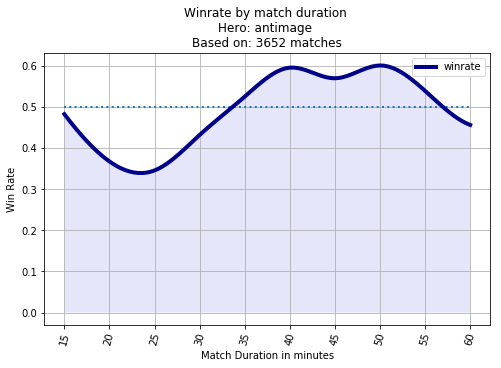

,winrate
duration_period,
"(9.95, 15.0]",0.483333
"(15.0, 20.0]",0.368132
"(20.0, 25.0]",0.346253
"(25.0, 30.0]",0.432647
"(30.0, 35.0]",0.526080
"(35.0, 40.0]",0.596715
"(40.0, 45.0]",0.570755
"(45.0, 50.0]",0.602041
"(50.0, 55.0]",0.540107


In [18]:
winrate_analysis('antimage')

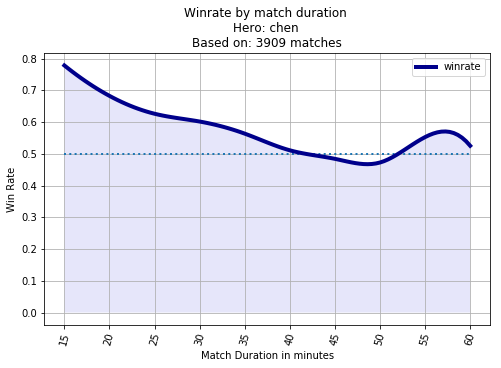

,winrate
duration_period,
"(9.95, 15.0]",0.778523
"(15.0, 20.0]",0.682667
"(20.0, 25.0]",0.626374
"(25.0, 30.0]",0.601810
"(30.0, 35.0]",0.563700
"(35.0, 40.0]",0.511152
"(40.0, 45.0]",0.484293
"(45.0, 50.0]",0.472727
"(50.0, 55.0]",0.552795


In [14]:
winrate_analysis(66)